In [1]:
import pandas as pd
from utils import *  
import os 
import numpy as np 
from scipy.stats.contingency import expected_freq
import re
from src.reference import annotate
from src.files import BLASTJsonFile
import seaborn as sns
from scipy.stats import chisquare
import glob
from matplotlib.lines import Line2D
import matplotlib as mpl

%load_ext autoreload 
%autoreload 2


In [2]:
def write_csv(df:pd.DataFrame, path:str=None):
    df = df.copy()
    
    is_overlap_at_query_n_terminus = lambda row : ((row.query_strand == 1) and (row.query_overlap == '10')) or ((row.query_strand == -1) and (row.query_overlap == '01'))
    is_overlap_at_top_hit_n_terminus = lambda row : ((row.top_hit_strand == 1) and (row.top_hit_overlap == '10')) or ((row.top_hit_strand == -1) and (row.top_hit_overlap == '01'))

    df['query_overlap_at_n_terminus'] = df.apply(is_overlap_at_query_n_terminus, axis=1)
    df['top_hit_overlap_at_n_terminus'] = df.apply(is_overlap_at_top_hit_n_terminus, axis=1)
    columns = ['species', 'genome_id', 'top_hit_protein_id', 'top_hit_product', 'top_hit_evidence_type', 'query_overlap_at_n_terminus', 'length', 'top_hit_length', 'overlap_length', 'top_hit_spurious', 'query_rbs_motif']
    df[columns].to_csv(path)
    print(f'write_csv: Wrote {len(df)} sequences to {path}.')

In [3]:
dataset_path = '../data/results/results-2/dataset.csv'
top_hit_predictions_path = '../data/results/results-2/top_hits_predict.csv'
predictions_path = '../data/results/results-2/dataset_predict.csv'

# Exclude genomes on which Prodigal did horrifically (I think I needed to use a different translation table). 
# Also, one of the excluded genomes belongs to an endosymbiont which is not assigned a phylum.
exclude_genome_ids = ['GCF_029854295.1', 'GCF_021057185.1', 'GCF_016097415.1'] 

results_df = load_results(dataset_path=dataset_path, top_hit_predictions_path=top_hit_predictions_path, predictions_path=predictions_path, exclude_genome_ids=exclude_genome_ids)

In [4]:
for model_label, df in results_df[results_df.match].groupby('model_label'):
    n_hypothetical = is_top_hit_hypothetical(df).sum()
    n_hypothetical_ab_initio = (is_top_hit_ab_initio(df) & is_top_hit_hypothetical(df)).sum()
    print(f'Num. {model_label} hypothetical matches with ab initio support:', n_hypothetical_ab_initio, f'({get_percent(n_hypothetical_ab_initio, n_hypothetical)})')


Num. real hypothetical matches with ab initio support: 5842 (79.65%)
Num. spurious hypothetical matches with ab initio support: 239 (91.22%)
Num. uncertain hypothetical matches with ab initio support: 224 (86.82%)


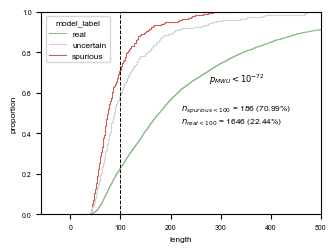

In [5]:
def figure_1(results_df:pd.DataFrame, path='../figures/results-2.1.match_figure-1.pdf'):

    fig, ax = get_figure()

    figure_df = results_df[(results_df.match & is_top_hit_hypothetical(results_df))].copy()
    palette = {'real':'darkseagreen', 'spurious':'indianred', 'uncertain':'lightgray'}
    # sns.kdeplot(figure_df, x='length', hue='model_label', palette=palette, common_norm=False)
    sns.ecdfplot(figure_df, x='length', hue='model_label', palette=palette)
    ax.set_xlim(xmax=500)

    ax.axvline(100, ls='--', lw=0.7, color='black')

    text = get_text('spurious < 100', (figure_df.spurious & (figure_df.length < 100)).sum(), figure_df.spurious.sum())
    text += get_text('real < 100', (figure_df.real & (figure_df.length < 100)).sum(), figure_df.real.sum())
    ax.text(0.5, 0.4, text, transform=ax.transAxes)
    ax.set_ylabel('proportion')

    p = get_mann_whitney_p_value(figure_df[figure_df.spurious]['length'].values, figure_df[figure_df.real]['length'].values, n_permutations=None)
    # ax.text(0.02, 0.9, '$p_{MWU}=$' + f'{p:.1e}', transform=ax.transAxes)
    ax.text(0.6, 0.65, '$p_{MWU} < 10^{-72}$', transform=ax.transAxes)

    save_figure(fig, path=path)

figure_1(results_df)

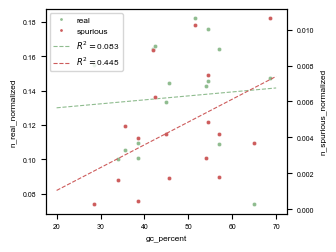

In [6]:
# If the model is flaging hypothetical proteins which are a product of ab intitio prediction error, there should be a correlation between
# genome GC content and the number of spurious hypothetical proteins, but no correlation for the real-predicted ones. 

# TODO: Might be a good idea to bootstrap confidence intervals. 

# The number of hypothetical proteins tracks genome size, so normalizing with respect to either the total
# genome size or the total number of hypothetical proteins is a good idea. 

def figure_2(results_df:pd.DataFrame, path='../figures/results-2.1.match_figure-2.pdf'):

    fig, ax_left = get_figure()
    ax_right = ax_left.twinx()

    # Only looking at the hypothetical matches. 
    genome_sizes = results_df.groupby('genome_id').size()
    figure_df = results_df[(results_df.match & is_top_hit_hypothetical(results_df))].copy()
    
    ax_df = pd.DataFrame(index=figure_df.genome_id.unique())
    ax_df['genome_size'] = genome_sizes
    ax_df['total'] = figure_df.groupby('genome_id').size() # Total number of hypothetical matches. 
    ax_df['gc_percent'] = figure_df.groupby('genome_id').gc_percent.first()
    ax_df['n_spurious'] =  figure_df.groupby('genome_id').spurious.sum()
    ax_df['n_real'] =  figure_df.groupby('genome_id').real.sum()
    ax_df['n_uncertain'] =  figure_df.groupby('genome_id').uncertain.sum()

    # Should I be normalizing with respect to the total genome size, or the total number of hypothetical proteins?
    # I think probably genome size, unless I just want to look at the ratio of real-to-spurious hypothetical proteins.
    for col in ['n_uncertain', 'n_real', 'n_spurious']:
            ax_df[f'{col}_normalized'] = ax_df[col] / ax_df.genome_size

    palette = {'real':'darkseagreen', 'spurious':'indianred', 'uncertain':'lightgray'}
    r2 = dict()
    for model_label, ax in zip(['real', 'spurious'], [ax_left, ax_right]):
        sns.scatterplot(ax_df, x='gc_percent', y=f'n_{model_label}_normalized', color=palette[model_label], ax=ax)
        x, y = ax_df['gc_percent'].values, ax_df[f'n_{model_label}_normalized'].values
        m, b = np.polyfit(x, y, 1)
        r2[model_label] = '$R^2=$' + str(np.round(np.corrcoef(x, y)[0, 1], 3))
        sns.lineplot(x=np.linspace(20, 70, 30), y=m * np.linspace(20, 70, 30) + b, color=palette[model_label], ax=ax, ls='--')

    handles = [Line2D([0], [0], marker='o', color='w', label='real', markerfacecolor=palette['real'], markersize=mpl.rcParams.get('lines.markersize'))]
    handles += [Line2D([0], [0], marker='o', color='w', label='spurious', markerfacecolor=palette['spurious'], markersize=mpl.rcParams.get('lines.markersize'))]
    handles += [Line2D([0], [0], color=palette['real'], label=r2['real'], ls='--')]
    handles += [Line2D([0], [0], color=palette['spurious'], label=r2['spurious'], ls='--')]

    ax_left.legend(handles=handles, loc='upper left')
    # ax_left.set_ylabel('normalized_count')

    save_figure(fig, path=path)

figure_2(results_df)

In [7]:
def table(results_df:pd.DataFrame, path:str='../data/results/results-2/match_spurious.csv'):
    '''All matches to annotated proteins which are marked as spurious.'''

    fields = ['top_hit_protein_id', 'top_hit_product', 'top_hit_model_label', 'top_hit_length', 'length', 'n_hits', 'top_hit_partial', 'genome_id']
    mask = results_df.spurious & results_df.match & (results_df.top_hit_product != 'hypothetical protein')
    table_df = results_df[mask][fields].copy()

    if path is not None:
        table_df.to_csv(path)
    return table_df

table_df = table(results_df)
table_df = has_alignment(table_df, min_bit_score=50).sort_values('aligned')
table_df

,top_hit_protein_id,top_hit_product,top_hit_model_label,top_hit_length,length,n_hits,top_hit_partial,genome_id,aligned
id,,,,,,,,,
NZ_AP025523.1_247,WP_317996048.1,FG-GAP repeat domain-containing protein,spurious,461,461,2,00,GCF_027923555.1,False
NZ_AP025523.1_1131,WP_317997499.1,alkaline phosphatase family protein,real,114,62,1,00,GCF_027923555.1,False
NZ_AP035449.1_2055,WP_400168263.1,four helix bundle protein,real,82,67,1,00,GCF_041154365.1,False
NZ_JAYGHR010000072.1_20,WP_323222006.1,CRISPR-associated endonuclease Cas2,spurious,67,67,2,00,GCF_034932365.1,False
NC_015499.1_869,WP_281054587.1,cupin domain-containing protein,spurious,84,72,1,00,GCF_000212395.1,False
NZ_CP063767.1_1730,WP_194371018.1,YARHG domain-containing protein,spurious,65,72,1,00,GCF_015277515.1,False
NZ_JAYGHR010000080.1_26,WP_323223092.1,DUF5838 family protein,spurious,75,75,1,00,GCF_034932365.1,False
NZ_JAYGHR010000080.1_31,WP_323223108.1,cyanobactin biosynthesis system PatB/AcyB/McaB...,spurious,83,83,1,00,GCF_034932365.1,False
NZ_JAYGHR010000096.1_19,WP_323224365.1,zinc ribbon domain-containing protein,real,123,84,1,00,GCF_034932365.1,False
